<a href="https://colab.research.google.com/github/ak224001/Sentiment-analysis/blob/master/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv("/content/drive/My Drive/IMDB_Sentiment_analysis/movie_data.csv")

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [0]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [0]:
import gensim

In [0]:
review_lines = list()
lines = df['review'].values.tolist()

In [0]:
for line in lines:
  tokens = word_tokenize(line)
  #conver to lowercase
  tokens = [w.lower() for w in tokens]
  #remove punctuation from lines
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #remove other that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  #stop words 
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  review_lines.append(words)

In [0]:
max_length = max([len(s) for s in review_lines])

 Average length of review in training dataset 122.12678
 Std Deviation  of review in training dataset 92.0244301630366


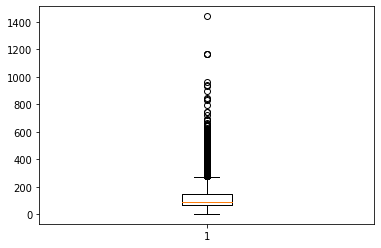

In [14]:
import numpy as np
import math
text_len = [len(review_lines[i]) for i in range(len(review_lines))]
print(" Average length of review in training dataset", np.mean(text_len))
print(" Std Deviation  of review in training dataset", np.std(text_len))
plt.boxplot(text_len)
plt.show()

In [0]:
#max length of sentance
max_length = 500

In [16]:
import nltk
from nltk.tokenize import word_tokenize
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

#pad sequence
word_index = tokenizer_obj.word_index
print("Found %s unique tokens" % len(word_index))


Found 134156 unique tokens


In [0]:
review_pad = pad_sequences(sequences,maxlen=max_length,padding ='post')

In [0]:
sentiment = df['sentiment'].values

In [0]:
num_words =len(word_index)+1

In [49]:
print('Indexing word vectors.')
import numpy as np
embeddings_index = {}
f = open('/content/drive/My Drive/glove_6B/glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [0]:
EMBEDDING_DIM=200
num_words =len(word_index)+1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word,i in word_index.items():
  if i>num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,Embedding,LSTM,Conv1D,MaxPooling1D,Dropout,GRU,Bidirectional
from tensorflow.keras.preprocessing import sequence



In [0]:
#split data into train and test
VALIDATION_SPLIT = .2
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]


In [87]:
num_validation_samples = int(VALIDATION_SPLIT*review_pad.shape[0])
num_validation_samples

10000

In [0]:
X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]


In [25]:
X_train_pad.shape

(45000, 500)

In [146]:
# create the model
Embedding_dim = 200
model = Sequential()
embedding_layer = Embedding(num_words, Embedding_dim ,weights=[embedding_matrix],input_length=max_length,trainable = False)
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 500, 200)          26831400  
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 500, 32)           19232     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 250, 32)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 200)               106400    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 201       
Total params: 26,957,233
Trainable params: 125,833
Non-trainable params: 26,831,400
_________________________________________________________________
None


In [147]:
# Fit the model
result = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=500)
# Final evaluation of the model
scores = model.evaluate(X_test_pad, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
80/80 [==============================] - 11s 135ms/step - loss: 0.5076 - accuracy: 0.7514 - val_loss: 0.4041 - val_accuracy: 0.8283
Epoch 2/10
80/80 [==============================] - 10s 127ms/step - loss: 0.3827 - accuracy: 0.8364 - val_loss: 0.3807 - val_accuracy: 0.8343
Epoch 3/10
80/80 [==============================] - 10s 127ms/step - loss: 0.3391 - accuracy: 0.8556 - val_loss: 0.3398 - val_accuracy: 0.8514
Epoch 4/10
80/80 [==============================] - 10s 127ms/step - loss: 0.3281 - accuracy: 0.8618 - val_loss: 0.3210 - val_accuracy: 0.8615
Epoch 5/10
80/80 [==============================] - 10s 127ms/step - loss: 0.3009 - accuracy: 0.8749 - val_loss: 0.3202 - val_accuracy: 0.8618
Epoch 6/10
80/80 [==============================] - 10s 128ms/step - loss: 0.3045 - accuracy: 0.8723 - val_loss: 0.3269 - val_accuracy: 0.8510
Epoch 7/10
80/80 [==============================] - 10s 127ms/step - loss: 0.2858 - accuracy: 0.8820 - val_loss: 0.3138 - val_accuracy: 0.8623

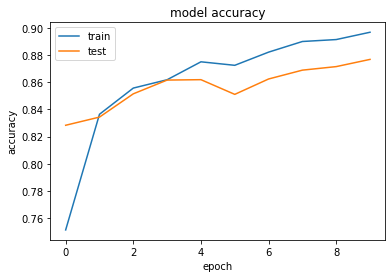

In [148]:
# summarize history for accuracy
history = result
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

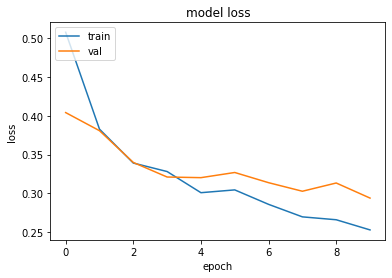

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model.summary()

In [22]:
X_train_pad.shape,y_train.shape,X_test_pad.shape,y_test.shape

((30000, 500), (30000,), (20000, 500), (20000,))

In [86]:
# create the model
embedding_vecor_length = 128
model = Sequential()
model.add(Embedding(num_words, embedding_vecor_length, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 128)          17172096  
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 500, 32)           12320     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 250, 32)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 17,190,721
Trainable params: 17,190,721
Non-trainable params: 0
_________________________________________________________________
None


In [87]:
# Fit the model
result = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=500)
# Final evaluation of the mode
scores = model.evaluate(X_test_pad, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
60/60 [==============================] - 18s 305ms/step - loss: 0.5813 - accuracy: 0.7105 - val_loss: 0.3872 - val_accuracy: 0.8389
Epoch 2/10
60/60 [==============================] - 17s 290ms/step - loss: 0.2578 - accuracy: 0.9064 - val_loss: 0.2849 - val_accuracy: 0.8877
Epoch 3/10
60/60 [==============================] - 17s 291ms/step - loss: 0.1385 - accuracy: 0.9585 - val_loss: 0.3072 - val_accuracy: 0.8855
Epoch 4/10
60/60 [==============================] - 18s 293ms/step - loss: 0.0747 - accuracy: 0.9822 - val_loss: 0.3439 - val_accuracy: 0.8814
Epoch 5/10
60/60 [==============================] - 17s 291ms/step - loss: 0.0464 - accuracy: 0.9907 - val_loss: 0.4062 - val_accuracy: 0.8781
Epoch 6/10
60/60 [==============================] - 17s 291ms/step - loss: 0.0330 - accuracy: 0.9940 - val_loss: 0.4532 - val_accuracy: 0.8732
Epoch 7/10
60/60 [==============================] - 18s 293ms/step - loss: 0.0317 - accuracy: 0.9932 - val_loss: 0.5015 - val_accuracy: 0.8621

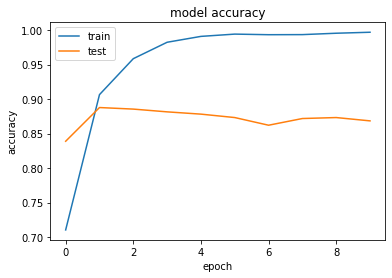

In [88]:
# summarize history for accuracy
history = result
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
s1 = "Movie was fantastic"
s2 = "moview was good"
s3 = "it was awesome"
s4 = "so bad movie"
s5 = "movie was good but so at the last it was horrible so bad"
s = [s1,s2,s3,s4,s5]
test_s_token = tokenizer_obj.texts_to_sequences(s)

In [0]:
test_s_token_pad = pad_sequences(test_s_token,maxlen=max_length,padding ='post')

In [144]:
model.predict(test_s_token_pad)

array([[0.8561844 ],
       [0.5657854 ],
       [0.72232056],
       [0.1381341 ],
       [0.15789826]], dtype=float32)

In [0]:
r = []

In [0]:
for line in s:
  tokens = word_tokenize(line)
  #conver to lowercase
  tokens = [w.lower() for w in tokens]
  #remove punctuation from lines
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #remove other that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  #stop words 
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  r.append(words)

In [0]:
test_r_token = tokenizer_obj.texts_to_sequences(r)

In [0]:
test_r_token_pad = pad_sequences(test_r_token,maxlen=max_length,padding ='post')

In [150]:
model.predict(test_r_token_pad)

array([[0.8356153 ],
       [0.6360109 ],
       [0.6890178 ],
       [0.18257987],
       [0.16914912]], dtype=float32)

In [0]:
com1 = "To be honest, this is the movie that motivated me to read the book of Exodus. I watch this movie again and again and it has blessed me so much. Exodus contains many precious truths about our blessed Lord Jesus Christ. It contains pictures, types, and the applications (like the blood on the doorpost) which have direct meaning on our Christian life today. Please do watch this movie and be blessed. See how the LORD planned beforehand and chose a deliverer to free the children of Israel and give them freedom, performed mighty miracles through him to save the children of Israel from the bitter bondage, protected Israel from the Pharaoh and his soldiers who sought to kill and destroy them, see the LORD's glory and His ways. Praise be to His wonderful name!"
com2 = "Highly impressed with the movie and it is an inspreration of my faith too be more stronger . I love this movie to watch again and again to be one off  the best believer . Thank you soo very much for the making of this movie. Love you and God bless the entire team .Blessings to all of you , who is sharing this for free ."
com3 = "I have always loved this movie. It is the best depiction of the bible on screen that I have watched. Also, Cecil B. DeMille was Jewish, so he wanted to get as close to the Bible as possible in making this movie. One of Charlton Heston's and Yul Brynner's best pictures...they were fantastic!!!"
com4 = "The greatest epic director was DeMille. However he cast that wooden actor for his looks and not for his acting skill , Charles Heston as Moses. Read all about DeMille in THE LOST  WORLD of DEMILLE by   JOHN KOBAL  DeMille cast his main characters in his epic biblical movies based on European art work who painted the great Jewish characters as tall virile Christians with long flowing hair. He forgot to consult his mother Jewish side for how people looked "
com5 = "I watched this movie around 20 years ago almost every friday night mainly because  i enjoyed it so much. Now that im alot older and understand it more i enjoy it alot more. Im not religious now but it really gives you a good understanding of the story of Moses."
com6 = "The movie was, is and will be amazing forever. All the actors had done a very good job. Excellent photography, costumes, biggest movie all the time with the imperishable Word of God from Exodus. All glory, paise, and honor to Almighty God,Who created Heaven and earth."
com7 = "For 1956 it was great. I was only 9, buI like to see it in 2019. The God I serve did part the Red Sea to save His chosen people. The very same God sent his only son to die so that we can have eternal life. Tomorrow I celebrate Easter because Jesus rose from the grave and one day soon He is coming back to claim His own. He is pure love."
com8 = "This movie delivers the respect an adaptation of the life of Moses deserves. It truly is one of the greatest films of all time. I once wrote a review for 'Prince of Egypt' which I thought was better but it depends on what you want to see. if you want to see a good character study of Moses, watch this movie. If you just want to watch an action movie or a musical or a kids movie, watch that one."
com9 = "This movie was AMAZING!!!! I'm an atheist and I loved it a lot!! honestly i don't know who Moses is but he seemed like a real jerk in my opinion, but everyone else in the movie seemed fine to me. 8/10 would recommend to my atheist Facebook group."
com10 = "Wonderful film about the children of Israel as they are in bondage in Egypt. They experience and see the hand of God through the 10 plagues. Finally  the Lord rescues them then guides them through the wilderness and calls them to be His people and covenants to be their God. Its an epic film showing the importance of obedience and faith in God the Father of Abraham, Isaac and Jacob."
comments = [com1,com2,com3,com4,com5,com6,com7,com8,com9,com10]

In [0]:
review = []

In [0]:
for line in comments:
  tokens = word_tokenize(line)
  #conver to lowercase
  tokens = [w.lower() for w in tokens]
  #remove punctuation from lines
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #remove other that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  #stop words 
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  review.append(words)

In [0]:
com_token = tokenizer_obj.texts_to_sequences(review)

In [0]:
com_token_pad = pad_sequences(com_token,maxlen=max_length,padding ='post')

In [151]:
model.predict(com_token_pad)

array([[0.9442054 ],
       [0.9882251 ],
       [0.93999845],
       [0.88237476],
       [0.97660553],
       [0.9667096 ],
       [0.8522855 ],
       [0.9893428 ],
       [0.7957951 ],
       [0.9764207 ]], dtype=float32)

In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
model.save('IMDB_Sentiment_Glove.h5')  # creates a HDF5 file 'my_model.h5'
